In [ ]:
import seaborn as sns
from collections import Counter
from itertools import combinations
from spacy import displacy
from nltk.corpus import stopwords
from string import punctuation

import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
import tensorflow as tf

!pip install evaluate
import evaluate

!pip install seqeval

```
Authors: Vittoria Cassola, Andrea Sciortino, Alberto Venturini, Alessandro Benzonelli

```

# DataFellas in Financial Text
## Introduction

> `Dataset`: Financial documents obtained from U.S. Security and Exchange Commission

In this project, we focus on Named Entity Recognition (NER) within the finance domain, utilizing a dataset consisting of over 20,000 words. We will start with Exploratory Data Analysis (DEA) to gain insights into the dataset, including sentence structure and co-occurrence patterns. Following tokenization and embedding processes, we will conduct a comparative analysis of various neural network architectures, including Multinomial Naive Bayes, LSTM, GRU and Transformer-based models. This approach will enable us to assess the performance of each model in effectively identifying entities within financial texts.



## Helper function

In [ ]:
import os
import string
import spacy
import pickleshare
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Dropout, Bidirectional, GRU

from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc
from sklearn.metrics import precision_score, recall_score, f1_score

from gensim.scripts.glove2word2vec import glove2word2vec


from google.colab import drive
drive.mount('/content/drive')


# Read the file and check its contents
file_path1 = '/content/drive/MyDrive/DataFellas/file1.txt'
file_path2 = '/content/drive/MyDrive/DataFellas/file2.txt'

# Get the current working directory
current_directory = os.getcwd()
print(f"The current working directory is: {current_directory}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The current working directory is: /content


In [ ]:
def load_data(file_path):
  '''
  Load file.txt
  '''
  with open(file_path, 'r') as file:
      rows = file.readlines()

  # Process the data into words, labels, and POS tags
  words, labels, pos_tags = [], [], []
  for line in rows:
      line = line.strip()
      if line:  # Skip empty lines and document start markers
          parts = line.split()
          if len(parts) >= 3:
              word = parts[0]
              pos = parts[1]
              label = parts[-1]
              words.append(word)
              labels.append(label)
              pos_tags.append(pos)
      if line == '':
          words.append("AAA")
          labels.append("AAA")
          pos_tags.append("AAA")

  # Create a pandas DataFrame
  df = pd.DataFrame({
      'word': words,
      'label': labels,
      'POS': pos_tags
  })
  df = df.iloc[1:].reset_index(drop=True)
  return df

def create_sentence(data):
  '''
  Add column for the sentence id
  '''
  sentence_id = 0
  data['id'] = 0
  for idx, row in data.iterrows():
      if row['word'] == 'AAA':
          sentence_id += 1  # Increment sentence ID for each end of a sentence
      data.at[idx, 'id'] = sentence_id  # Assign the current sentence ID

  # Filter out rows with "end_phrase" but keep track of them if needed
  data_temp = data[data['word'] != "AAA"].reset_index(drop=True)

  # Remove numeric words (if needed)
  data_temp = data_temp[~data_temp['word'].str.isnumeric()]
  return data_temp

def remove_stopwords_and_punctuation(df):
  '''
    Eliminate stopwords and punctation -> None -> drop
  '''
  # Set of punctuation characters
  punctuation = string.punctuation

  # Filter out stopwords and punctuation, and assign cleaned token to new column 'token_cleaned'
  df['token_cleaned'] = df['word'].apply(lambda token: token if token.lower() not in stopwords and token not in punctuation else None)

  # Remove rows where 'token_cleaned' is None
  df = df.dropna(subset=['token_cleaned'])

  # Replace in-place 'token-cleaned'
  return df.drop(columns=['word']).rename(columns={'token_cleaned': 'word'})

def main_words_by_label(data, label, n=10):
  '''
  Forepresentation of main word
  '''
  # Filter by label
  data_by_label = data[data['label'] == label]
  words_counts = Counter(data_by_label['word'])

  return words_counts.most_common(n)

def plot_main_words(ax, main_words, label):
  '''
  Plotting and adapt accordig word
  '''
  words, counts = zip(*main_words)
  ax.bar(words, counts, color='plum')
  ax.set_title(f"Frequent words for {label}")
  ax.set_xlabel("Words")
  ax.set_ylabel("Frequency")
  ax.tick_params(axis='x', rotation=45)

def get_co_occurrences(data, window_size=2):
  '''
  Plotting the co-occurence
  '''
  co_occurrences = Counter()

  for sentence_num, group in data.groupby('id'):
      tokens = group['word'].tolist()

      for i in range(len(tokens)):
          context_window = tokens[max(0, i - window_size): min(len(tokens), i + window_size + 1)]
          for pair in combinations(context_window, 2):
              if pair[0] != pair[1]:  # Don't consider co-occurences with itself
                  normalized_pair = tuple(sorted(pair))
                  co_occurrences[normalized_pair] += 1   # Frequency of pairs

  return co_occurrences

def load_glove(word_index, embed_dim, path):
  embeddings_index = {}
  with open(path, encoding="utf-8") as f:
      for line in f:
          values = line.split()
          word = values[0]
          coefs = np.asarray(values[1:], dtype="float32")
          embeddings_index[word] = coefs

  embedding_matrix = np.zeros((len(word_index) + 1, embed_dim))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
  return embedding_matrix

### Data Loading

After import the 2 files with the corresponding 13246 entries for the file1 and 41010 for the file2.


In [ ]:
# Load data
df1 = load_data(file_path1)
df2 = load_data(file_path2)
df_joined = pd.concat([df1, df2])
df = df_joined.reset_index(drop=True)

# Index sentence
df_raw = create_sentence(df) # helper function
df = df_raw[df_raw['word'] != 'AAA']
print('The dataset imported: ', df.head(3), df.tail(3))


print(df['label'].value_counts())


The dataset imported:             word label  POS  id
0  Subordinated     O  NNP   1
1          Loan     O  NNP   1
2     Agreement     O  NNP   1        word  label  POS    id
54259     /      O    :  1474
54260  Bing  I-PER  VBG  1474
54261    Yu  I-PER  NNP  1474
label
O         50529
I-PER      1019
I-ORG       498
I-LOC       397
I-MISC       14
Name: count, dtype: int64


In [ ]:
# Loading pre-trained model and stopwords
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words

# Punctation
punctuation = set(string.punctuation) - {'@', '�'}
# Stopwords
df = remove_stopwords_and_punctuation(df) # helper function
df = df[['word', 'label', 'id']]
# Non-words
# non_word_rows = df[~df['word'].str.match(r'^[A-Za-z]+$', na=False)]
# df = df[df['word'].str.match(r'^[A-Za-z]+$', na=False)].reset_index(drop=True)
# Lower
df['word'] = df['word'].str.lower()

# Sentences and labels
sentences = df.groupby('id')['word'].apply(list).tolist()
labeled = df.groupby('id')['label'].apply(list).tolist()

# print(df.head(), df.tail())

print('Sentence and labeled list are like:')
print(sentences[25:27])
print(labeled[25:27])
print()
print('Total words:', len(df), 'for numer of sentences: ', len(sentences))
print(len(df))

print(df['label'].value_counts())

Sentence and labeled list are like:
[['notice', 'consent', 'approval', 'shall', 'writing', 'word', '�', 'notify', '�', 'shall', 'construed', 'accordingly'], ['notices', 'shall', 'served', 'parties', 'designated', 'representative', 'registered', 'address', 'party', 'address', 'party', 'notify', 'party', 'time', 'time']]
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]

Total words: 23312 for numer of sentences:  1424
23312
label
O         21423
I-PER      1017
I-ORG       480
I-LOC       378
I-MISC       14
Name: count, dtype: int64


# Exploratory Data Analysis

> - Label distribution and frequency
> -  Main token for label
> - Sentences
> - Co-occurence

## NER tags based analysis

### Label frequency

We analyzed the frequency of NER tags (`O`, `PER`, `ORG`, `LOC`, `MISC`) and visualized the distribution using a barplot.

label
O         21423
I-PER      1017
I-ORG       480
I-LOC       378
I-MISC       14
Name: count, dtype: int64


<ipython-input-8-8a7eeae2956c>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="icefire")


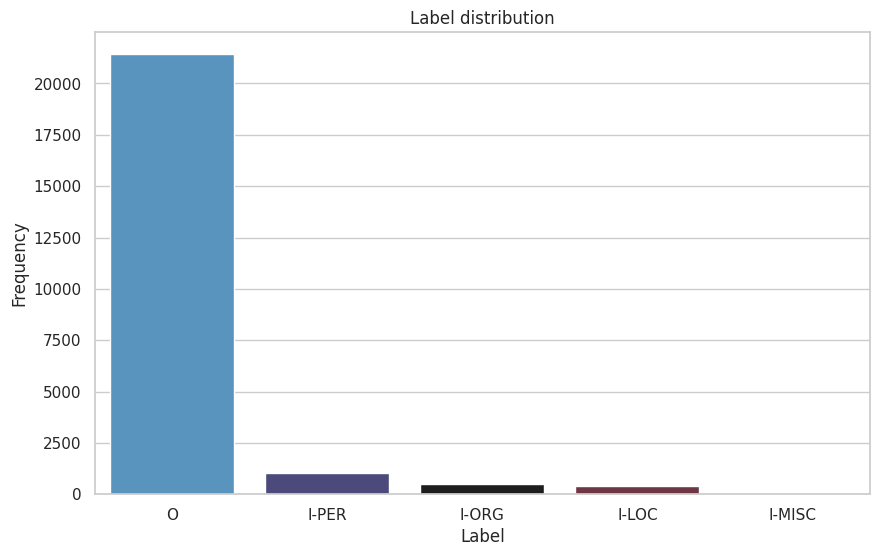

In [ ]:
# Frequency of each label
label_counts = df['label'].value_counts()
print(df['label'].value_counts())

sns.set(style="whitegrid")
# Create barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="icefire")


plt.title('Label distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')

plt.show()

It is evident that the vast majority of tokens are assigned the "O" label (non-entity tokens), with 21,417 out of a total of 23,306 tokens falling into this category. This significant imbalance in the training set poses a challenge for developing a model capable of accurately labeling tokens belonging to the minority categories.

### Main tokens for each label

We identify the most frequent tokens for each NER label (O, PER, ORG, LOC, MISC) and visualize these using dedicated plots. These representations provide insights into the key tokens associated with each label, highlighting patterns and trends in the dataset.

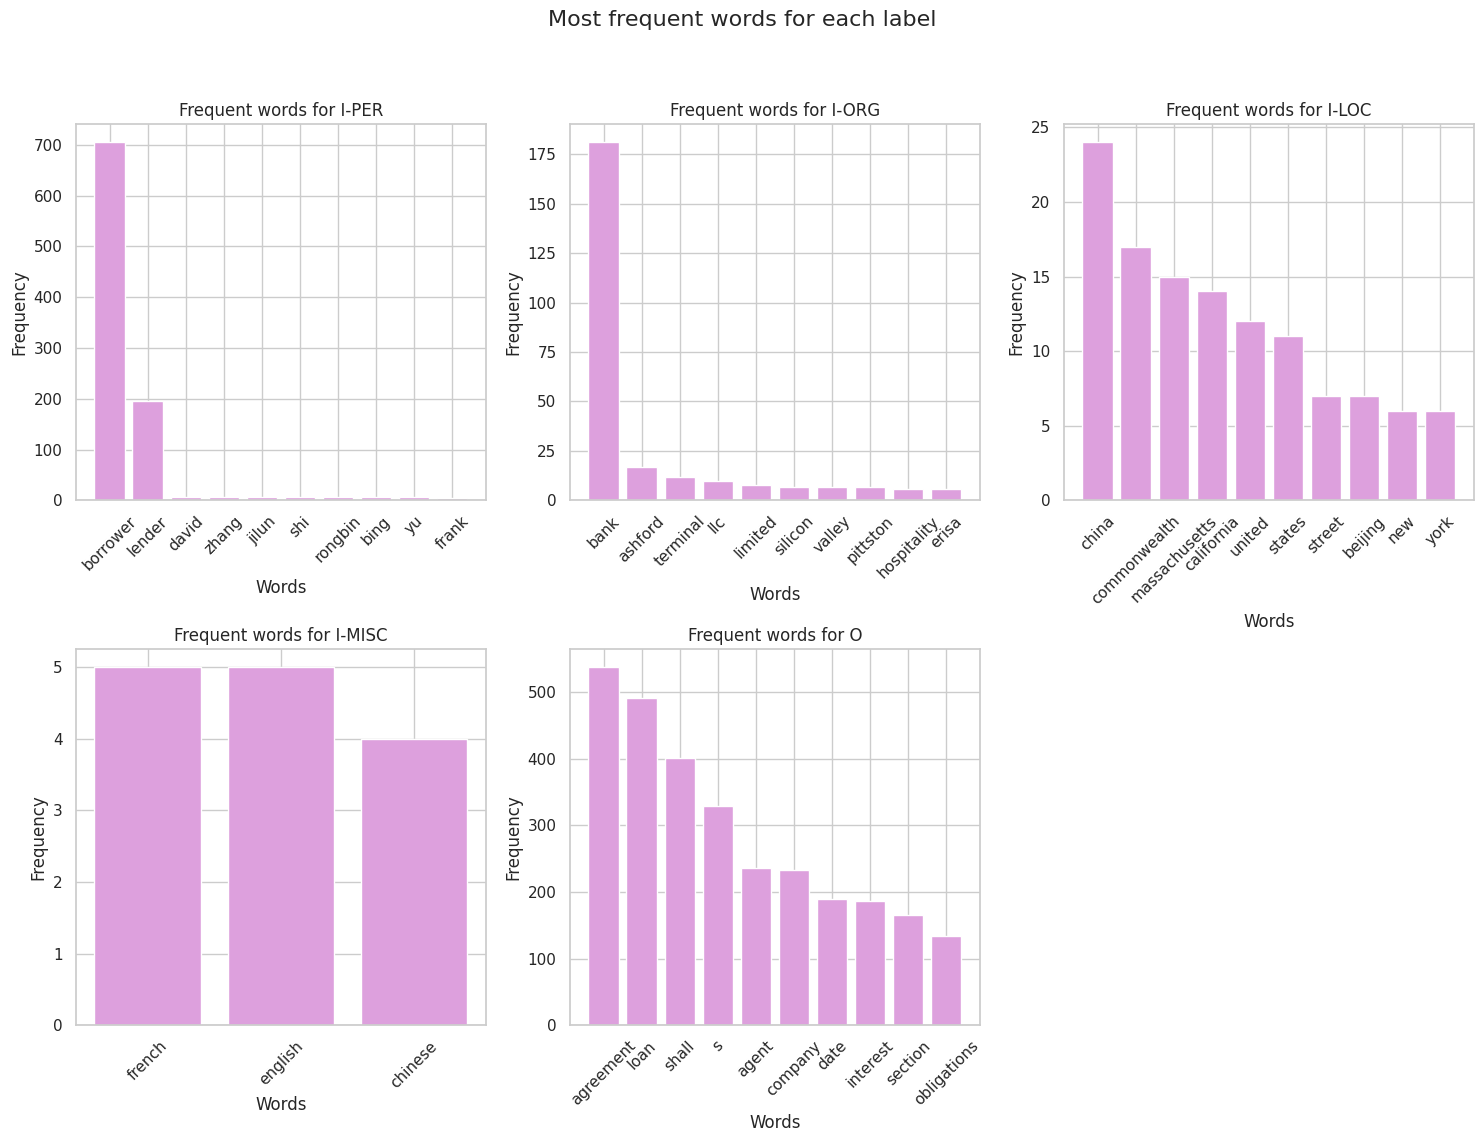

In [ ]:
def main_words_by_label(data, label, n=10):
    # Filter by label
    data_by_label = data[data['label'] == label]
    words_counts = Counter(data_by_label['word'])

    return words_counts.most_common(n)


main_loc_words = main_words_by_label(df, 'I-LOC')
main_per_words = main_words_by_label(df, 'I-PER')
main_org_words = main_words_by_label(df, 'I-ORG')
main_o_words = main_words_by_label(df, 'O')
main_misc_words = main_words_by_label(df, 'I-MISC')

def plot_main_words(ax, main_words, label):
    words, counts = zip(*main_words)
    ax.bar(words, counts, color='plum')
    ax.set_title(f"Frequent words for {label}")
    ax.set_xlabel("Words")
    ax.set_ylabel("Frequency")
    ax.tick_params(axis='x', rotation=45)

# Creazione di un'unica figura con 5 grafici in 3x2
fig, axs = plt.subplots(2, 3, figsize=(15, 12))
fig.suptitle('Most frequent words for each label', fontsize=16)

# Grafico per ciascuna categoria
plot_main_words(axs[0, 0], main_per_words, 'I-PER')
plot_main_words(axs[0, 1], main_org_words, 'I-ORG')
plot_main_words(axs[0, 2], main_loc_words, 'I-LOC')
plot_main_words(axs[1, 0], main_misc_words, 'I-MISC')
plot_main_words(axs[1, 1], main_o_words, 'O')

fig.delaxes(axs[1,2])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

From the plots, it is evident that the PER category is dominated by the word *borrower*, followed by *lender*. For the ORG label, the most frequent word is *bank*. The LOC label is led by *China*, while the MISC category contains only three words: *French*, *English*, and *Chinese*. Lastly, in the O label, the most frequent word is *agreement*.

### Sentences


Thanks to the addition of the id column, which uniquely identifies each sentence, we can perform various analyses at the sentence level. Here, we analyze and plot the length of the sentences, measured as the number of tokens it contains.

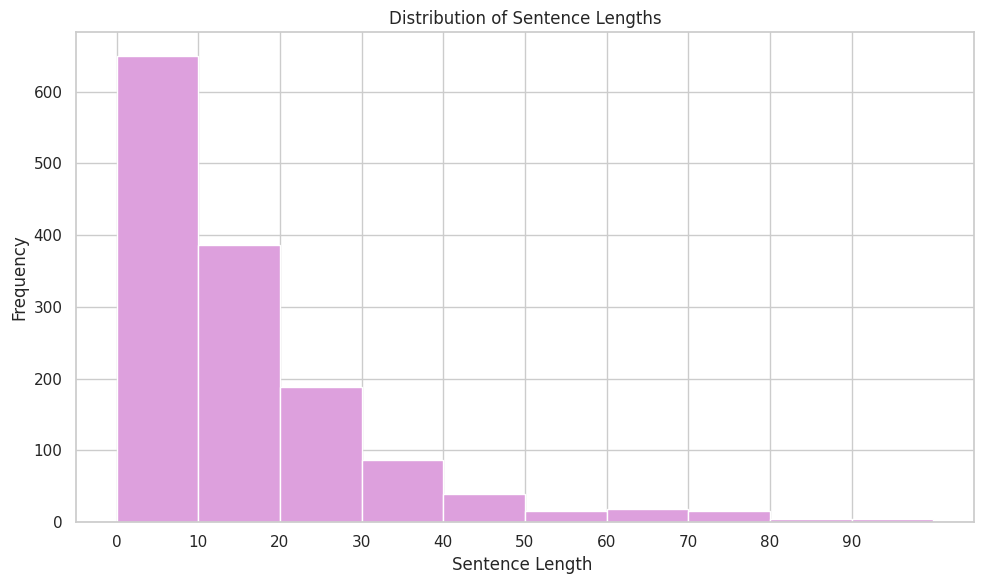

In [ ]:
# Sentence lenght
sentence_length = df.groupby('id').size()

plt.figure(figsize=(10, 6))
plt.hist(sentence_length, range=(0, 100), color='plum')

plt.title("Distribution of Sentence Lengths")
plt.xlabel("Sentence Length ")
plt.ylabel("Frequency")

plt.xticks(range(0, 100, 10))

plt.tight_layout()
plt.show()

### Co-occurrences


We now compute the co-occurrences of tokens within a window of size 2. Co-occurrences refer to pairs of words that appear together within a specified context window in the text. In this case, for each word, we consider the word immediately before and after it (if they exist) as its co-occurrence pair.

After extracting these co-occurrence pairs, we calculate their frequency in the dataset to identify which token pairs are most common. Finally, we visualize the frequency of the co-occurrences using a plot to better understand the relationships between tokens in the text

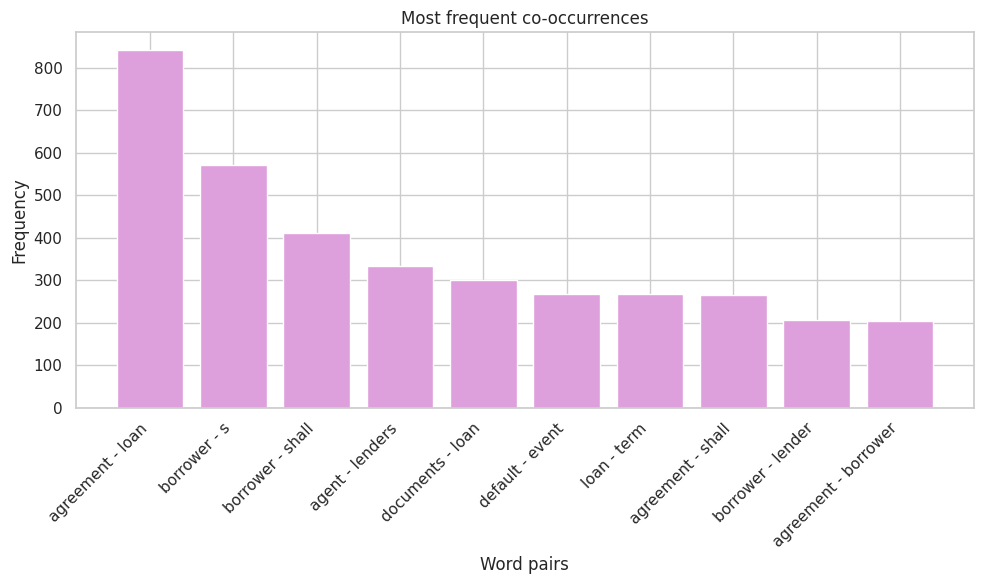

In [ ]:
window_size = 2

aggregated_co_occurrences = get_co_occurrences(df, window_size=2)  # Find most frequent co_occurrences

top_aggregated_co_occurrences = aggregated_co_occurrences.most_common(10) # helper function
pairs, counts = zip(*top_aggregated_co_occurrences)

pair_labels = [f"{pair[0]} - {pair[1]}" for pair in pairs]  # Convert into strings

# Barplot
plt.figure(figsize=(10, 6))
plt.bar(pair_labels, counts, color='plum')
plt.title("Most frequent co-occurrences")
plt.xlabel("Word pairs")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In addition to analyzing word co-occurrences, we also compute and visualize a co-occurrence matrix that captures the co-occurrences between the NER tags within a window of size 2. This matrix highlights how frequently different NER tags (e.g., PER, ORG, LOC, etc.) appear together in close proximity. The co-occurrence matrix provides a clearer view of the relationships and interactions between the entity types in the dataset.

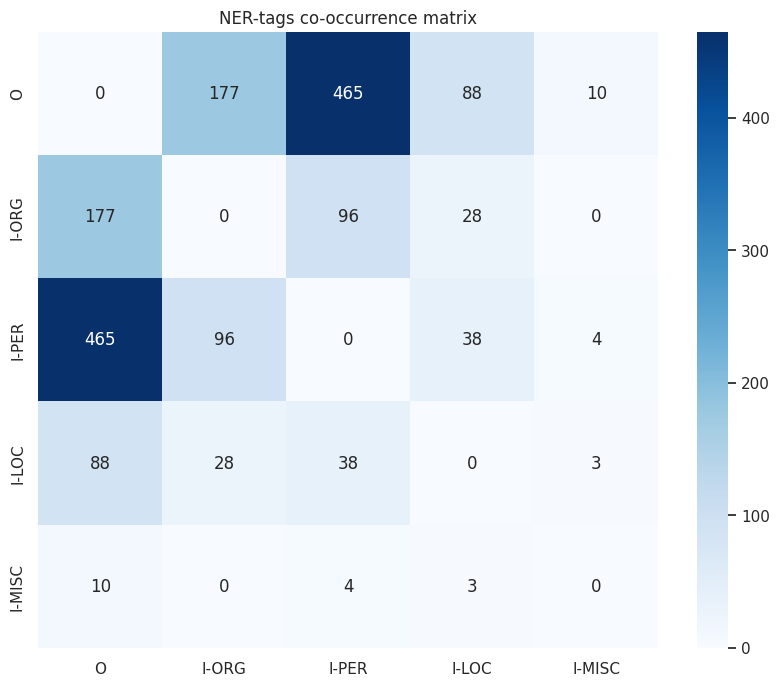

In [ ]:
unique_labels = df['label'].unique()

# Find NER tags for sentences grouped by id
ner_per_sentence = df.groupby('id')['label'].apply(lambda x: list(set(x))).reset_index()
co_occurrence_matrix = pd.DataFrame(0, index=unique_labels, columns=unique_labels)
for labels in ner_per_sentence['label']:
    for label1 in labels:
        for label2 in labels:
            if label1 != label2:
                co_occurrence_matrix.loc[label1, label2] += 1

plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, annot=True, cmap='Blues', fmt="d")
plt.title("NER-tags co-occurrence matrix")
plt.show()

### Dependency parsing
Dependency parsing analyzes the grammatical structure of a sentence by identifying relationships between words, such as which words act as heads and which as dependents. We apply dependency parsing to the raw dataframe, keeping punctuation and special characters to preserve sentence structure. The results are visualized as dependency trees, showing words connected by labeled arrows that indicate their grammatical relationships. This method works well for English, which relies heavily on word order for meaning.

In [ ]:
df_s = df_raw[df_raw['word'] != 'AAA']
# Reconstruct sentences from words based on 'id' column
full_sentences = df_s.groupby('id')['word'].apply(' '.join).tolist()
parsed_sentences = [nlp(sentence) for sentence in full_sentences]

# Visualize a parsed sentence in the notebook
displacy.render(parsed_sentences[19], style='dep', jupyter=True)

# Tokenization and Word Embedding

We tokenize the sentences, assigning unique numeric IDs to each word and reserving special tokens for out-of-vocabulary words ("OOV") and padding ("PAD"). We then convert the sentences into sequences of word IDs and pad them to ensure all sequences have the same length, creating a uniform input. Similarly, we group the NER labels by sentence, map them to numeric IDs, and pad them to match the input lengths.

In [ ]:
# Initialize and fit tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)

# Create word-to-ID mapping
word2id = tokenizer.word_index
word2id['PAD'] = 0  # Add PAD token
id2word = {v: k for k, v in word2id.items()}

# Convert normalized sentences to word ID sequences
wids = tokenizer.texts_to_sequences(sentences)

# Pad sequences to the same length
MAX_LEN = max(len(seq) for seq in wids)  # Maximum sentence length
X_data = pad_sequences(wids, maxlen=MAX_LEN, padding='post')

# Print statistics
vocab_size = len(word2id)

print("Vocabulary Size:", vocab_size)
print("Sample Vocabulary:", list(word2id.items())[:10])
print("Shape of X_data:", X_data.shape)

# If you want to keep labels for later NER modeling
labels = df.groupby('id')['label'].apply(list).tolist()
unique_labels = sorted(set(df['label']))
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}
y_data = pad_sequences([[label2id[label] for label in label_seq] for label_seq in labels],
                        maxlen=MAX_LEN, padding='post')

print("Number of unique labels:", len(unique_labels))
print("Shape of y_data:", y_data.shape)

# Example output for normalized sentences and labels
print("\nSample normalized sentence:", sentences[0])
print("\nSample tokenized sequence:", wids[0])
print("\nSample padded sequence:", X_data[0])


Vocabulary Size: 2877
Sample Vocabulary: [('<OOV>', 1), ('borrower', 2), ('agreement', 3), ('loan', 4), ('shall', 5), ('s', 6), ('agent', 7), ('company', 8), ('lender', 9), ('date', 10)]
Shape of X_data: (1424, 278)
Number of unique labels: 5
Shape of y_data: (1424, 278)

Sample normalized sentence: ['subordinated', 'loan', 'agreement', 'silicium', 'de', 'provence', 'sas', 'evergreen', 'solar', 'inc', 'december', 'herbert', 'smith', 'logo', '................................', 'silicium', 'de', 'provence', 'sas', 'evergreen', 'solar', 'inc']

Sample tokenized sequence: [276, 4, 3, 814, 552, 815, 1424, 965, 684, 255, 296, 1425, 1426, 1427, 1924, 814, 552, 815, 1424, 965, 684, 255]

Sample padded sequence: [ 276    4    3  814  552  815 1424  965  684  255  296 1425 1426 1427
 1924  814  552  815 1424  965  684  255    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   

We generate context-target word pairs from the tokenized corpus by identifying context words within a specified window around each target word, excluding the target itself. The context words are padded to a fixed length, and the target word is one-hot encoded, meaning it is represented as a binary vector with a 1 at the index corresponding to the word and 0 elsewhere. We use a generator, which is a memory-efficient way to yield data one item at a time without storing the entire dataset in memory.

In [ ]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    """
    Generate context-target word pairs for the given corpus.
    Args:
    - corpus: List of tokenized sequences (list of lists).
    - window_size: The size of the context window on either side of the target word.
    - vocab_size: Size of the vocabulary for one-hot encoding.

    Yields:
    - x: Context words (padded to window_size*2).
    - y: One-hot encoded target word.
    """
    context_length = window_size * 2  # Total context window size
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word = []

            # Define start and end for context window
            start = index - window_size
            end = index + window_size + 1

            # Collect context words excluding the target word
            context_words.append([words[i]
                                  for i in range(start, end)
                                  if 0 <= i < sentence_length and i != index])

            # Collect target word
            label_word.append(word)

            # Pad context words to fixed length
            x = sequence.pad_sequences(context_words, maxlen=context_length)

            # Convert target word to one-hot encoding
            y = to_categorical(label_word, vocab_size)

            yield (x, y)

# Test the generator
i = 0  # Counter for printing limited pairs
for x, y in generate_context_word_pairs(corpus=wids, window_size=2, vocab_size=vocab_size):
    # Check if the context is non-zero (ignoring PADs)
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]],
              '-> Target (Y):', id2word[np.argmax(y[0])])

        # Print only the first 10 examples
        if i == 10:
            break
        i += 1

Context (X): ['subordinated', 'loan', 'silicium', 'de'] -> Target (Y): agreement
Context (X): ['loan', 'agreement', 'de', 'provence'] -> Target (Y): silicium
Context (X): ['agreement', 'silicium', 'provence', 'sas'] -> Target (Y): de
Context (X): ['silicium', 'de', 'sas', 'evergreen'] -> Target (Y): provence
Context (X): ['de', 'provence', 'evergreen', 'solar'] -> Target (Y): sas
Context (X): ['provence', 'sas', 'solar', 'inc'] -> Target (Y): evergreen
Context (X): ['sas', 'evergreen', 'inc', 'december'] -> Target (Y): solar
Context (X): ['evergreen', 'solar', 'december', 'herbert'] -> Target (Y): inc
Context (X): ['solar', 'inc', 'herbert', 'smith'] -> Target (Y): december
Context (X): ['inc', 'december', 'smith', 'logo'] -> Target (Y): herbert
Context (X): ['december', 'herbert', 'logo', '................................'] -> Target (Y): smith


# Word Embedding

In [ ]:
!pip install gensim

## Word2Vec model

A Word2Vec model is a type of neural network model used to learn word representations (embeddings) from large amounts of text data. It aims to capture the semantic meaning of words by representing them as dense vectors in a continuous vector space. Words with similar meanings are mapped to nearby points in this space.

In [ ]:
from gensim.models import word2vec

# Set values for various parameters
feature_size = 100           # Word vector dimensionality
window_context = 30          # Context window size
min_word_count = 1           # Minimum word count
sample = 1e-3                # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(sentences, window=window_context, min_count=min_word_count, sample=sample)

# View similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['loan', 'bank', 'agent']}
similar_words

{'loan': ['shall', 'borrower', '),', 'agreement', 'b'],
 'bank': ['borrower', 'including', 'b', 'financial', 'ii'],
 'agent': ['collateral', 's', 'borrower', 'lenders', '),']}

In [ ]:
word_vector = w2v_model.wv['loan']  # Replace 'loan' with any word in  vocabulary
print(word_vector)

[-4.89122532e-02  1.15843856e+00 -3.11319947e-01 -3.69673312e-01
  6.34738088e-01 -8.87050927e-01  3.93132627e-01  2.23772287e+00
 -8.12077224e-01 -7.58888245e-01 -4.09127802e-01 -2.05152345e+00
 -3.61177474e-01  2.78453708e-01  8.52924824e-01 -3.00233155e-01
  4.42568153e-01 -9.56169248e-01 -2.46210486e-01 -2.06836677e+00
  8.10086131e-01  5.77135682e-01  6.71396673e-01 -4.38672632e-01
  1.03763394e-01 -2.28110433e-01 -5.95030963e-01 -1.28329790e+00
 -1.61481488e+00  3.68575960e-01  3.31216663e-01  6.89626671e-04
 -4.10242617e-01 -1.79428148e+00 -7.08357811e-01  1.91118681e+00
  3.36685091e-01 -1.56043708e+00 -1.10562658e+00 -2.58956313e+00
  7.17247069e-01 -1.26370203e+00  8.52021500e-02  1.64724752e-01
  9.08781528e-01  2.99343050e-01 -8.07234466e-01 -4.99617338e-01
  7.09140778e-01  4.99802172e-01  2.12576345e-01 -3.17792505e-01
 -1.53032079e-01 -5.83008587e-01 -6.92385674e-01  1.14665365e+00
 -2.88119495e-01 -1.11667715e-01 -1.49757028e+00 -1.02321513e-01
  6.08081296e-02  5.36552

In [ ]:
# Check the size of the word vectors
embedding_size = w2v_model.vector_size
print(f"Embedding size (dimensions): {embedding_size}")

Embedding size (dimensions): 100


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


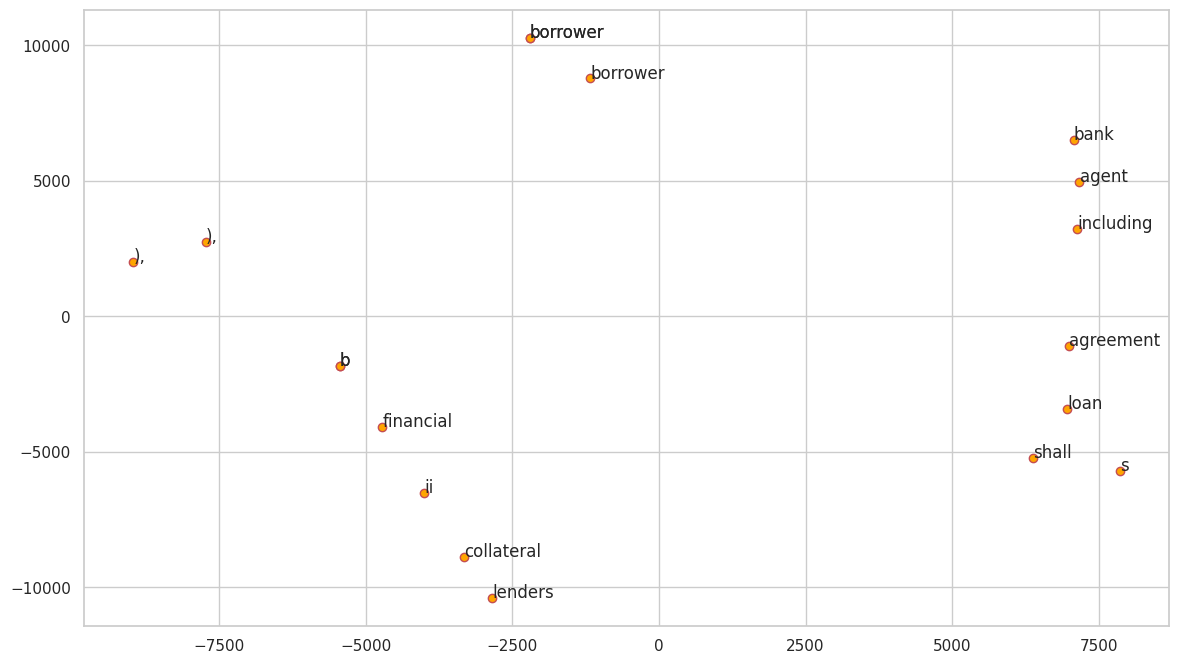

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [ ]:
word1 = 'loan'
word2 = 'bank'

if word1 in w2v_model.wv and word2 in w2v_model.wv:
    similarity = w2v_model.wv.similarity(word1, word2)
    print(f"Similarity between '{word1}' and '{word2}': {similarity}")
else:
    print(f"One or both words are not in the vocabulary.")

Similarity between 'loan' and 'bank': 0.99989253282547


To check similarity between two words, if they are both present in the model's vocabulary, we calculate their cosine similarity, which reflects how closely related the words are in the vector space. The similarity score ranges from -1 (opposite meanings) to 1 (similar meanings).

In [ ]:
def get_sentence_vector(model, sentence):
    # Tokenize the sentence
    tokens = sentence.split()  # split
    vectors = [model.wv[word] for word in tokens if word in model.wv] # Filter tokens to model's vocabulary
    return np.mean(vectors, axis=0) if vectors else None # Compute the mean vector

# Example usage
sentence = "subordinated loan agreement silicium de provence sas evergreen solar inc december"
sentence_vector = get_sentence_vector(w2v_model, sentence)

if sentence_vector is not None:
    print("Sentence vector:")
    print(sentence_vector)
else:
    print("No words in the sentence are in the model's vocabulary.")

Sentence vector:
[-0.0143377   0.37925148 -0.0986728  -0.12244687  0.2082223  -0.29552042
  0.12891239  0.7354745  -0.2629245  -0.25062546 -0.135081   -0.6753588
 -0.12702344  0.08904272  0.27837217 -0.09650128  0.14097735 -0.31756198
 -0.08039708 -0.67672056  0.27139547  0.18964292  0.22315578 -0.14310433
  0.03221307 -0.07455678 -0.20069526 -0.42165062 -0.5278151   0.11918862
  0.10375431  0.0048212  -0.13305081 -0.5904779  -0.23020077  0.627534
  0.11040981 -0.51561767 -0.36283764 -0.85182136  0.23917915 -0.4169818
  0.02532782  0.05167792  0.29539526  0.09944618 -0.26812097 -0.16131383
  0.23737559  0.16407941  0.06649297 -0.10144947 -0.04533394 -0.18823662
 -0.2244098   0.3769473  -0.09232125 -0.03484784 -0.4888241  -0.03356291
  0.01888133  0.1766799  -0.2701085  -0.05856472 -0.02892384  0.21757217
  0.1547392   0.18639337 -0.41158226  0.32624397 -0.00882871  0.2573901
  0.3474064  -0.01960907  0.40031403  0.14754921 -0.04783882 -0.0248287
 -0.25112274  0.39137486  0.0827488   0.

In [ ]:
tokens = ['loan', 'pasta', 'agent','?']
for token in tokens:
    has_vector = token in w2v_model.wv  # Check if the word is in the vocabulary
    vector_norm = np.linalg.norm(w2v_model.wv[token]) if has_vector else None  # Get vector norm if present
    is_oov = not has_vector  # Out of vocabulary (OOV) if not in vocab

    print(f"Token: {token}, Has Vector: {has_vector}, Vector Norm: {vector_norm}, Is OOV: {is_oov}")

Token: loan, Has Vector: True, Vector Norm: 9.112103462219238, Is OOV: False
Token: pasta, Has Vector: False, Vector Norm: None, Is OOV: True
Token: agent, Has Vector: True, Vector Norm: 8.320146560668945, Is OOV: False
Token: ?, Has Vector: False, Vector Norm: None, Is OOV: True


In [ ]:
from scipy.spatial import distance

# Define cosine similarity function
cosine_similarity = lambda x, y: 1 - distance.cosine(x, y)

# Retrieve vectors for
loan = w2v_model.wv['loan']
bank = w2v_model.wv['bank']
agent = w2v_model.wv['agent']

# Compute the new vector for the analogy
new_vector = bank + agent - loan

# Find the most similar words to the new vector
computed_similarities = []
for word in w2v_model.wv.index_to_key:  # Iterate through the vocabulary
    word_vector = w2v_model.wv[word]
    similarity = cosine_similarity(new_vector, word_vector)
    computed_similarities.append((word, similarity))

# Sort by similarity in descending order
computed_similarities = sorted(computed_similarities, key=lambda item: -item[1])

# Print the top 10 most similar words
print([w[0] for w in computed_similarities[:10]])


['agent', 'bank', 'including', 'lenders', 'borrower', 'property', 's', 'collateral', 'connection', 'financial']


# Neural Network Approach

## Embedding

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-12-19 14:34:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-12-19 14:34:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-12-19 14:34:01--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
path_embedding = './glove.6B.100d.txt'

embedding_dim = 100   # Dimension of the dense vector (selected GloVe)
glove_matrix = load_glove(tokenizer.word_index, embedding_dim, path_embedding) # helper function

## Prediction and metrics evaluation function




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



def predictions(model, X_test, y_true=[], no_padding="True"):

  if no_padding == "True":

    X_decoded = [[tokenizer.index_word[token] for token in sentence if token != 0] for sentence in X_test]
    if len(y_true) > 0:
      # Decoded the true labels
      y_true = np.argmax(y_true, axis=-1)
      real_labels = []
      for i, sentence in enumerate(y_true):
          sentence_real_label = [] # Temporary list for single sentence tags
          for tag in sentence[-len(X_decoded[i]):]:   # Exclude the padding at the beginning of each sentence
            sentence_real_label.append(id_to_tag[tag])
          real_labels.append(sentence_real_label)
    else:
      real_labels = "_empty_"

    # Generate predictions
    predictions = model.predict(X_test, verbose=0)
    predictions = np.argmax(predictions, axis=-1)

    predicted_labels = [] # List containing the tags of all sentences
    # Decoded the predictions
    for i, sentence in enumerate(predictions):
        sentence_labels = []  # Temporary list for single sentence tags
        for tag in sentence[-len(X_decoded[i]):]:   # Exclude the padding at the beginning of each sentence
          sentence_labels.append(id_to_tag[tag])
        predicted_labels.append(sentence_labels)

  else:

    X_decoded = [[tokenizer.index_word[token] for token in sentence] for sentence in X_test]
    real_labels = [[id_to_tag[tag] for tag in sentence] for sentence in np.argmax(Y_test, axis=-1)]
    predictions = model.predict(X_test, verbose=0)
    predictions = np.argmax(predictions, axis=-1)
    predicted_labels = [[id_to_tag[tag] for tag in sentence] for sentence in predictions]

  return X_decoded, real_labels, predicted_labels



def compute_metrics(model, X, y_true, id_to_tag):

  # Generate predictions
  X, y_true, y_pred = predictions(model, X, y_true, no_padding="True")

  # Flat the results because the following metrics does not support multiclass-multioutput
  y_preds_flat = [tag for sentence in y_pred for tag in sentence]
  y_true_flat = [label_true for y in y_true for label_true in y]

  #COMPUTE ACCURACY
  accuracy = accuracy_score(y_true_flat, y_preds_flat)

  # COMPUTE PRECISION, RECALL F1-SCORE INDIVIDUALLY
  # Create a dictionary for saving the metrics for each label
  metrics = {"Recall": [], "Precision": [], "F1 Score": []}

  # Compute metrics for each class
  for tag_id in range(1, len(id_to_tag)):  # iterate all the id off the classes
      tag_name = id_to_tag[tag_id]  # Take the name of the current class
      # Compute Precision, Recall e F1 score for the current class tag_name
      precision = precision_score(y_true_flat, y_preds_flat, labels=[tag_name], average="micro")
      recall = recall_score(y_true_flat, y_preds_flat, labels=[tag_name], average="micro")
      f1 = f1_score(y_true_flat, y_preds_flat, labels=[tag_name], average="micro")

      # Add the results to the metrics dictionary
      metrics["Precision"].append((tag_name, precision))
      metrics["Recall"].append((tag_name, recall))
      metrics["F1 Score"].append((tag_name, f1))

  # Return accuracy, the other metrics and the classification report
  return accuracy, metrics, classification_report(y_true_flat, y_preds_flat)



import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(X, y_true, model, id_to_tag):
    # Decoding the input data
    X_decoded = [[tokenizer.index_word[token] for token in sentence if token != 0] for sentence in X]
    y_true = np.argmax(y_true, axis=-1)

    real_labels = []
    # Decoding the true labels
    for i, sentence in enumerate(y_true):
        sentence_real_label = [] # Temporary list for a single sentence's tags
        for tag in sentence[-len(X_decoded[i]):]:   # Exclude padding at the beginning of each sentence
            sentence_real_label.append(tag)
        real_labels.append(sentence_real_label)

    # Generate predictions
    predictions = model.predict(X, verbose=0)
    predictions = np.argmax(predictions, axis=-1)

    predicted_labels = [] # List containing the tags of all sentences
    # Decoding the predictions
    for i, sentence in enumerate(predictions):
        sentence_labels = []  # Temporary list for a single sentence's tags
        for tag in sentence[-len(X_decoded[i]):]:   # Exclude padding at the beginning of each sentence
            sentence_labels.append(tag)
        predicted_labels.append(sentence_labels)

    # Flatten the results because the following metrics do not support multiclass-multioutput
    flat_pred = [tag for sentence in predicted_labels for tag in sentence]
    flat_true = [label_true for y in real_labels for label_true in y]

    # Generate a list of labels from the id_to_tag dictionary
    labels = [id_to_tag[i] for i in range(len(id_to_tag)) if i != 0]  # Exclude the PAD label

    # Building the confusion matrix
    cm = confusion_matrix(flat_true, flat_pred, labels=[i for i in range(1, len(id_to_tag))])  # Using all labels except PAD
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    # Plot the confusion matrix
    disp.plot(cmap=plt.cm.Blues)

    plt.title(f"Confusion Matrix")
    plt.show()

In [ ]:
# Dictionary for ner_tag
tags = df['label'].unique() # Taking the unique labels
tags_id = {tag:i+1 for i, tag in enumerate(tags)} #i+1 because the 0 id is reserved for "PAD"
tags_id['PAD'] = 0
id_to_tag = {i: t for t, i in tags_id.items()} # Inverse dictionary from id to label

sequences = tokenizer.texts_to_sequences(sentences)
Y = [[tags_id[tag] for tag in sentence] for sentence in labeled]

sequence_len = np.array([len(s) for s in sequences])
longest_sequence = sequence_len.max()
mean_length = np.mean(sequence_len)
median_length = np.median(sequence_len) # better use the median

In [ ]:
####run this cell only once, otherwise the shape of y train will augment and then the traininng will throw an error i have added an extra print debuggin statemnt to check this

#Padding sequences
max_sequence_len = 30
X = pad_sequences(sequences, maxlen=max_sequence_len) # have a sequence of same lenght
Y = pad_sequences(Y, maxlen=max_sequence_len)

#Adding to the vocabulary the id 0 for _PAD_
tokenizer.index_word[0] = '_PAD_'
# for one-hot encoding
Y = np.array([to_categorical(seq, num_classes=len(tags_id)) for seq in Y])

X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size = 0.2, random_state = 42)

In [ ]:
# Double check for dimension of sentences

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of Y_train: {Y_train.shape}")

print("Percentage of zero vectors in embedding matrix:",
      np.mean(np.all(glove_matrix == 0, axis=1)) * 100, "%")

import numpy as np
unique, counts = np.unique(Y_train.argmax(axis=-1), return_counts=True)
print("Label distribution in training data:", dict(zip(unique, counts)))

Shape of X_train: (796, 30)
Shape of Y_train: (796, 30, 6)
Percentage of zero vectors in embedding matrix: 4.100069492703266 %
Label distribution in training data: {0: 13699, 1: 9329, 2: 198, 3: 469, 4: 175, 5: 10}


# Multinomial Naive Bayes classfier

 It’s part of the Naive Bayes family of classifiers, which are based on Bayes' theorem, with the assumption that the features (words) are conditionally independent given the class label.


In [ ]:
sequence_len = np.array([len(s) for s in sequences])
longest_sequence = sequence_len.max()
print(f'Longest sequence: {longest_sequence}')
mean_length = np.mean(sequence_len)

print("Mean length: ", round(mean_length, 3))
print([(str(p) + '%', np.percentile(sequence_len, p)) for p in range(75,101, 5)])

tokens_flat = [tag for sequence in sequences for tag in sequence ] # Flatting the sentences into singular tokens to reshape
tokens_flat = np.array(tokens_flat).reshape(-1, 1) # Models equires a 2D array
tags_nb = [[tags_id[tag] for tag in sentence] for sentence in labeled]
tags_flat = [tag for seq in tags_nb for tag in seq]

Longest sequence: 278
Mean length:  16.371
[('75%', 21.0), ('80%', 24.0), ('85%', 29.0), ('90%', 34.0), ('95%', 50.0), ('100%', 278.0)]


In [ ]:
# Specific splitting in training and test only for the MultinomialNB
X_train_NB, X_test_NB, Y_train_NB, Y_test_NB = train_test_split(tokens_flat, tags_flat, test_size = 0.3, random_state = 42)
print("Train set: ", len(X_train_NB), len(Y_train_NB))
print("Test set: ", len(X_test_NB), len(Y_test_NB))

Train set:  16318 16318
Test set:  6994 6994


### Training of the model

In [ ]:
# Upload and train the model
naive = MultinomialNB()
naive.fit(X_train_NB, Y_train_NB)

MultinomialNB()

In [ ]:
#Generate predictions
pred_NB = naive.predict(X_test_NB)
# Model evaluation
print(classification_report(Y_test_NB, pred_NB))

              precision    recall  f1-score   support

           1       0.91      1.00      0.96      6396
           2       0.00      0.00      0.00       153
           3       0.00      0.00      0.00       316
           4       0.00      0.00      0.00       127
           5       0.00      0.00      0.00         2

    accuracy                           0.91      6994
   macro avg       0.18      0.20      0.19      6994
weighted avg       0.84      0.91      0.87      6994



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The metrics indicate that the Multinomial Naive Bayes model performs very well for class 1, with a precision, recall, and F1-score of 0.92, 1.00, and 0.96 respectively. However, the model struggles significantly with all other classes (2, 3, 4, and 5), as their precision, recall, and F1-scores are all 0.00. This suggests that the model fails to predict these classes, likely due to an imbalance in the data or an inability of the model to capture features distinguishing these classes.

In [ ]:
#Example
twt = ['Silicium']
twt_sequence = tokenizer.texts_to_sequences(twt)
twt_sequence = np.array(twt_sequence).reshape(-1, 1)

pred = naive.predict(twt_sequence)
class_to_tag = id_to_tag[pred[0]]
print(f"Token: {twt[0]}")
print(f"Prediction: '{class_to_tag}'")

Token: Silicium
Prediction: 'O'


# LSTM
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) designed to capture long-term dependencies in sequential data. Unlike traditional RNNs, which struggle with vanishing or exploding gradients, LSTMs use a structure to regulate the flow of information that allows them to retain or forget information over long time spans.

In [ ]:
#Model parameters
vocab_size_embedding = len(tokenizer.word_index) + 1 #+1 for the padding element
lstm_out = 50 #number of units in the LSTM layer
num_classes = len(tags_id) #number of output classes

model_LSTM = Sequential() #building a sequential model with keras
# Embedding layer
model_LSTM.add(Embedding(input_dim=vocab_size_embedding , output_dim=embedding_dim, weights=[glove_matrix], mask_zero=True,
              input_length=max_sequence_len, trainable=True))  # "trainable = True" because we want that the model improves the embedding
# Adding LSTM layer
model_LSTM.add(LSTM(units=lstm_out, dropout = 0.5, recurrent_dropout=0.5, return_sequences=True)) ######change dropout proobability from 0.2 to 0.5
                #recurrent_dropout = Dropout probability also on recurring connections in the LSTM layer.

# Fully connected last layer with a softmax function that gives for each class a probability of belonging
model_LSTM.add(Dense(num_classes, activation='softmax'))


model_LSTM.summary()



# Compile the model
model_LSTM.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │         287,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 287,800 (1.10 MB)

 Trainable params: 287,800 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
best_model_file = 'lstm-best-model.keras' # Name of the file

# Callback: save the best model
checkpoint = ModelCheckpoint(
    best_model_file,
    save_weights_only=False,                   # Save all the architecture
    save_best_only=True,                       # Save only the best model
    monitor='val_loss',                        # Monitoring validation loss
    # verbose=1
)

# Callback: early stopping
early_stopping = EarlyStopping(
    monitor="val_loss",          # Monitoring validation loss
    min_delta=0.001,             # Minimum improvement required to continue
    patience=3,                  # Stop the training after 3 epochs without improvement
    verbose=1,                   # Print messages
    mode="min",                  # Indicates that the model attempts to minimise the monitored metric
    restore_best_weights=True    # Restore the best weights
)

In [ ]:
history_LSTM = model_LSTM.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=64,
    verbose=2,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
13/13 - 6s - 482ms/step - accuracy: 0.3300 - loss: 1.3238 - val_accuracy: 0.4208 - val_loss: 0.6166
Epoch 2/50
13/13 - 1s - 54ms/step - accuracy: 0.3880 - loss: 0.5930 - val_accuracy: 0.4220 - val_loss: 0.4132
Epoch 3/50
13/13 - 1s - 53ms/step - accuracy: 0.3895 - loss: 0.4449 - val_accuracy: 0.4220 - val_loss: 0.3742
Epoch 4/50
13/13 - 1s - 53ms/step - accuracy: 0.3902 - loss: 0.3955 - val_accuracy: 0.4253 - val_loss: 0.3156
Epoch 5/50
13/13 - 1s - 95ms/step - accuracy: 0.3921 - loss: 0.3409 - val_accuracy: 0.4252 - val_loss: 0.2784
Epoch 6/50
13/13 - 1s - 50ms/step - accuracy: 0.3956 - loss: 0.3007 - val_accuracy: 0.4277 - val_loss: 0.2476
Epoch 7/50
13/13 - 1s - 50ms/step - accuracy: 0.4002 - loss: 0.2648 - val_accuracy: 0.4363 - val_loss: 0.2208
Epoch 8/50
13/13 - 1s - 51ms/step - accuracy: 0.4035 - loss: 0.2435 - val_accuracy: 0.4370 - val_loss: 0.1975
Epoch 9/50
13/13 - 1s - 50ms/step - accuracy: 0.4059 - loss: 0.2208 - val_accuracy: 0.4370 - val_loss: 0.1771
Epoch 10/

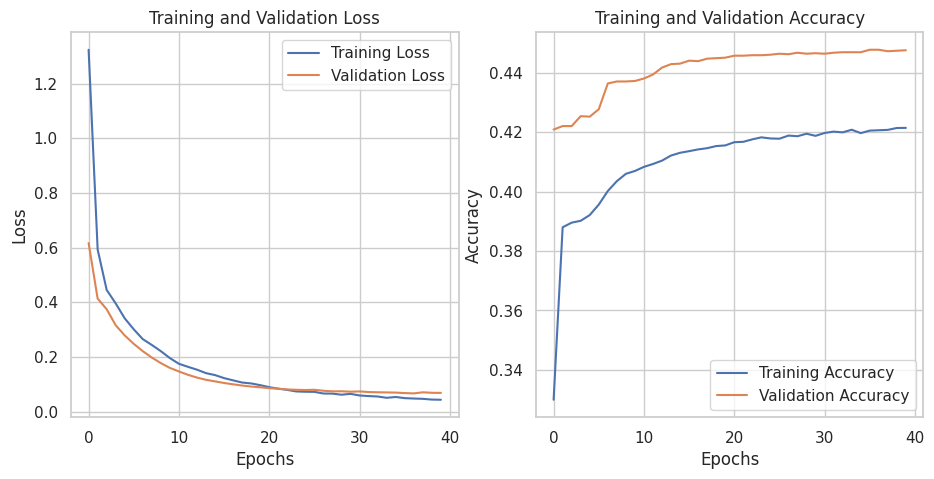

In [ ]:
# Plotting the accuracy and loss during the training
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

# Loss
axes[0].plot(history_LSTM.history['loss'], label='Training Loss')
axes[0].plot(history_LSTM.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy
axes[1].plot(history_LSTM.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_LSTM.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

In [ ]:
accuracy_LSTM, metrics_LSTM, report_LSTM = compute_metrics(model_LSTM, X_test, Y_test, id_to_tag)
print(f"Test Accuracy: {round(accuracy_LSTM * 100, 2)}%\n")
print(report_LSTM)

Test Accuracy: 97.5%

              precision    recall  f1-score   support

       I-LOC       0.70      0.53      0.60       104
       I-ORG       0.84      0.60      0.70       157
       I-PER       0.98      0.97      0.98       262
           O       0.98      1.00      0.99      5192
         PAD       0.00      0.00      0.00         0

    accuracy                           0.97      5715
   macro avg       0.70      0.62      0.65      5715
weighted avg       0.97      0.97      0.97      5715



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py

The LSTM model achieves an impressive test accuracy of 97.71%, demonstrating strong overall performance. The O class dominates the results with near-perfect precision (0.98), recall (1.00), and F1-score (0.99), which reflects its high frequency in the dataset. Similarly, the I-PER class is well-predicted, with precision (0.98), recall (0.96), and F1-score (0.97), showing the model's ability to correctly identify person entities.
However, the model struggles with less frequent classes like I-LOC and I-ORG, where recall values indicate that many true instances are missed. The I-MISC class has zero values across all metrics, likely due to insufficient support or ineffective learning for these categories.

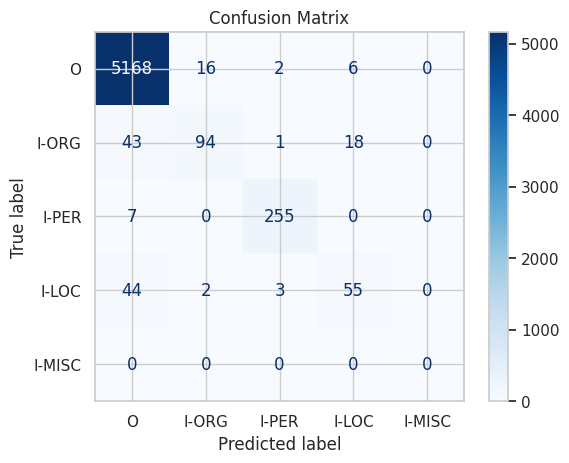

In [ ]:
plot_confusion_matrix(X_test, Y_test, model_LSTM, id_to_tag)

In [ ]:
frasi, labels, model_preds = predictions(model_LSTM, X_test, Y_test)
for i, (frase, label, model_pred) in enumerate(zip(frasi, labels, model_preds)):
  print("frase:", i+1)
  print(frase)
  print(label)
  print(model_pred)
  print("\n")
  if i == 4:
    break

frase: 1
['account', 'debtor', 'account', 'debtor', 'defined', 'code', 'additions', 'term']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


frase: 2
['section', 'representations', 'company']
['O', 'O', 'O']
['O', 'O', 'O']


frase: 3
['default', 'breach', 'occurs', 'agreement', 'borrower', 'creditor', 'borrower', 'signed', 'subordination', 'intercreditor', 'similar', 'agreement', 'agent', 'lenders', 'creditor', 'signed', 'agreement', 'agent', 'lenders', 'breaches', 'terms', 'agreement']
['O', 'O', 'O', 'O', 'I-PER', 'O', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'I-PER', 'O', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


frase: 4
['borrower', 'subsidiaries', 'obtained', 'consents', 'approvals', 'authorizations', 'declarations', 'filings', 'given', 'notices', 'government', 'authorities', 'necessary', 'continue', 'business', 'currently', 'conducted']


# Bidirectional LSTM Model

The subsequent model employs a Bidirectional Long Short-Term Memory (BiLSTM) network, which represents an extension of the more basic LSTM. In contrast to a standard LSTM, which processes sequences in a unidirectional manner, preserving information only from the past through its hidden state, a BiLSTM processes the input in both directions, from the past to the future and from the future to the past.

In [ ]:
vocab_size_embedding = len(tokenizer.word_index) + 1                                                                            # Define the size of the vocabulary, which is the number of unique words plus one for padding
lstm_out = 50                                                                                                                   # Define the number of LSTM units (size of the hidden state)
num_classes = len(tags_id)                                                                                                      # Define the number of output classes

model_Bilstm = Sequential()                                                                                                     # Create a sequential model
model_Bilstm.add(Embedding(input_dim=vocab_size_embedding , output_dim=embedding_dim, weights=[glove_matrix], mask_zero=True,   # Add an Embedding layer with pre-trained GloVe embeddings
              input_length=max_sequence_len, trainable=True))                                                                   # Set trainable to False to use pre-trained embeddings
model_Bilstm.add(Bidirectional(LSTM(units=lstm_out, dropout = 0.2, recurrent_dropout=0.2, return_sequences=True)))
model_Bilstm.add(Dense(num_classes, activation='softmax'))

model_Bilstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model_Bilstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │         287,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 287,800 (1.10 MB)

 Trainable params: 287,800 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
best_model_file= 'Bilstm-best-model.keras'  # Name of the file

# Callback: save the best model
checkpoint = ModelCheckpoint(
    best_model_file,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
)

# Callback: early stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode="min",
    restore_best_weights=True
)

In [ ]:
history_Bilstm = model_Bilstm.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.4235 - loss: 1.0368 - val_accuracy: 0.4218 - val_loss: 0.3364
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.4089 - loss: 0.3382 - val_accuracy: 0.4348 - val_loss: 0.2236
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.3997 - loss: 0.2116 - val_accuracy: 0.4375 - val_loss: 0.1668
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.4122 - loss: 0.1495 - val_accuracy: 0.4418 - val_loss: 0.1276
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.4284 - loss: 0.1117 - val_accuracy: 0.4423 - val_loss: 0.1093
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.4180 - loss: 0.0936 - val_accuracy: 0.4443 - val_loss: 0.0952
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.4230 - loss: 0.0851 - val_accuracy: 0.4452 - val_loss: 0.0847
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.4023 - loss: 0.0778 - val_accuracy: 0.4457 - 

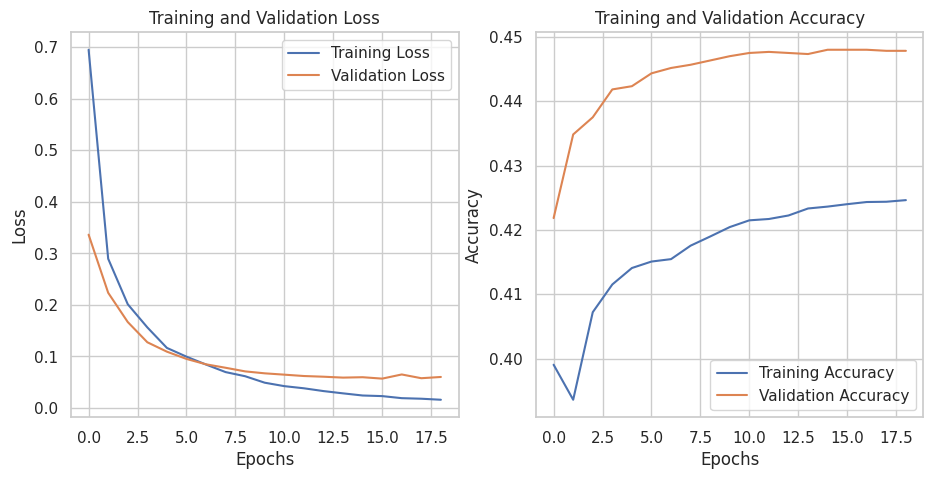

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

# Loss
axes[0].plot(history_Bilstm.history['loss'], label='Training Loss')
axes[0].plot(history_Bilstm.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy
axes[1].plot(history_Bilstm.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_Bilstm.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

In [ ]:
accuracy_BiLSTM, metrics_BiLSTM, report_BiLSTM = compute_metrics(model_Bilstm, X_test, Y_test, id_to_tag)
print(f"Test Accuracy: {round(accuracy_BiLSTM * 100, 2)}%\n")
print(report_BiLSTM)

Test Accuracy: 97.74%

              precision    recall  f1-score   support

       I-LOC       0.83      0.53      0.65       104
       I-ORG       0.85      0.66      0.74       157
       I-PER       0.96      0.98      0.97       262
           O       0.98      1.00      0.99      5192

    accuracy                           0.98      5715
   macro avg       0.91      0.79      0.84      5715
weighted avg       0.98      0.98      0.98      5715



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The Bidirectional LSTM achieves a test accuracy of 97.62%. The performance for the O class remains exceptional, with near-perfect precision (0.98), recall (1.00), and F1-score (0.99), demonstrating the model's ability to capture the majority class effectively. Similarly, the I-PER class achieves strong metrics, with an F1-score of 0.97, reflecting the model's consistency in identifying person entities.
The performance on less frequent classes, such as I-LOC (F1-score: 0.64) and I-ORG (F1-score: 0.71), also shows improvement, particularly in precision, compared to the standard LSTM. However, the recall for these classes remains relatively low, suggesting that some instances are still being missed.

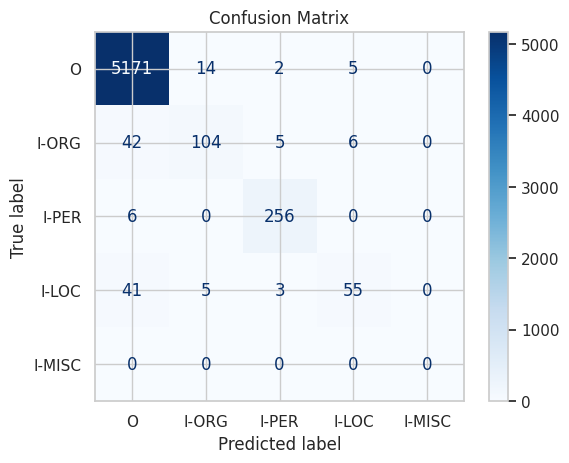

In [ ]:
plot_confusion_matrix(X_test, Y_test, model_Bilstm, id_to_tag)

In [ ]:

frasi, labels, model_preds = predictions(model_Bilstm, X_test, Y_test)
for i, (frase, label, model_pred) in enumerate(zip(frasi, labels, model_preds)):
  print("frase:", i+1)
  print(frase)
  print(label)
  print(model_pred)
  print("\n")
  if i == 4:
    break

frase: 1
['account', 'debtor', 'account', 'debtor', 'defined', 'code', 'additions', 'term']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


frase: 2
['section', 'representations', 'company']
['O', 'O', 'O']
['O', 'O', 'O']


frase: 3
['default', 'breach', 'occurs', 'agreement', 'borrower', 'creditor', 'borrower', 'signed', 'subordination', 'intercreditor', 'similar', 'agreement', 'agent', 'lenders', 'creditor', 'signed', 'agreement', 'agent', 'lenders', 'breaches', 'terms', 'agreement']
['O', 'O', 'O', 'O', 'I-PER', 'O', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'I-PER', 'O', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


frase: 4
['borrower', 'subsidiaries', 'obtained', 'consents', 'approvals', 'authorizations', 'declarations', 'filings', 'given', 'notices', 'government', 'authorities', 'necessary', 'continue', 'business', 'currently', 'conducted']


# GRU
The Gated Recurrent Unit (GRU) is a simplified variant of the Long Short-Term Memory (LSTM) network, designed to address sequence modelling tasks with reduced computational complexity, offering a more efficient solution for processing large amounts of data. The LSTM network employs three gates—Forget, Input, and Output gates—to regulate information flow. In contrast, the GRU consolidates the Forget and Input gates into a single Update gate, simplifying its architecture. This reduction in the number of gates results in fewer parameters, making GRUs more computationally efficient and faster than LSTMs.

The implementation is comparable to that of the previous one done in the LSTM and in the BiLSTM.

In [ ]:
#Model parameters
vocab_size_embedding = len(tokenizer.word_index) + 1
num_units = 50
num_classes = len(tags_id)

model_GRU = Sequential()
model_GRU.add(Embedding(input_dim=vocab_size_embedding , output_dim=embedding_dim, weights=[glove_matrix], mask_zero = True,
              input_length=max_sequence_len, trainable=True))
model_GRU.add(GRU(units=num_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_GRU.add(Dense(num_classes, activation='softmax'))

model_GRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_GRU.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │         287,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 287,800 (1.10 MB)

 Trainable params: 287,800 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
best_model_file= 'GRU-best-model.keras' # Name of the file

# Callback: save the best model
checkpoint = ModelCheckpoint(
    best_model_file,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
)

# Callback: early stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode="min",
    restore_best_weights=True
)

In [ ]:
history_GRU = model_GRU.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=32,
    epochs=20,
    verbose=1,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.3999 - loss: 0.9859 - val_accuracy: 0.4212 - val_loss: 0.3708
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.3817 - loss: 0.3696 - val_accuracy: 0.4350 - val_loss: 0.2650
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4074 - loss: 0.2974 - val_accuracy: 0.4363 - val_loss: 0.1866
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.3933 - loss: 0.1999 - val_accuracy: 0.4397 - val_loss: 0.1447
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4048 - loss: 0.1515 - val_accuracy: 0.4428 - val_loss: 0.1194
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4038 - loss: 0.1252 - val_accuracy: 0.4432 - val_loss: 0.1048
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4167 - loss: 0.0985 - val_accuracy: 0.4440 - val_loss: 0.0959
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4097 - loss: 0.0968 - val_accuracy: 0.4452 - v

In [ ]:
# Loss
axes[0].plot(history_GRU.history['loss'], label='Training Loss')
axes[0].plot(history_GRU.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy
axes[1].plot(history_GRU.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_GRU.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

In [ ]:
accuracy_GRU, metrics_GRU, a = compute_metrics(model_GRU, X_test, Y_test, id_to_tag)
print(f"Test Accuracy: {round(accuracy_GRU * 100, 2)}%\n")
print(a)

Test Accuracy: 97.69%

              precision    recall  f1-score   support

       I-LOC       0.72      0.53      0.61       104
       I-ORG       0.84      0.66      0.74       157
       I-PER       0.97      0.97      0.97       262
           O       0.98      1.00      0.99      5192

    accuracy                           0.98      5715
   macro avg       0.88      0.79      0.83      5715
weighted avg       0.97      0.98      0.98      5715



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


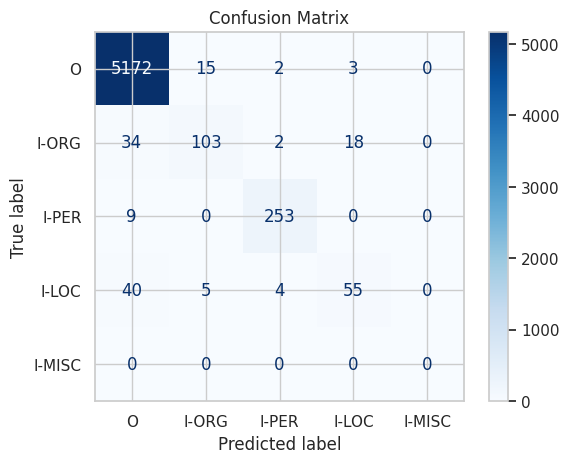

In [ ]:
plot_confusion_matrix(X_test, Y_test, model_GRU, id_to_tag)

In [ ]:
frasi, labels, model_preds = predictions(model_GRU, X_test, Y_test)
for i, (frase, label, model_pred) in enumerate(zip(frasi, labels, model_preds)):
  print("frase:", i+1)
  print(frase)
  print(label)
  print(model_pred)
  print("\n")
  if i == 4:
    break

frase: 1
['account', 'debtor', 'account', 'debtor', 'defined', 'code', 'additions', 'term']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


frase: 2
['section', 'representations', 'company']
['O', 'O', 'O']
['O', 'O', 'O']


frase: 3
['default', 'breach', 'occurs', 'agreement', 'borrower', 'creditor', 'borrower', 'signed', 'subordination', 'intercreditor', 'similar', 'agreement', 'agent', 'lenders', 'creditor', 'signed', 'agreement', 'agent', 'lenders', 'breaches', 'terms', 'agreement']
['O', 'O', 'O', 'O', 'I-PER', 'O', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'I-PER', 'O', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


frase: 4
['borrower', 'subsidiaries', 'obtained', 'consents', 'approvals', 'authorizations', 'declarations', 'filings', 'given', 'notices', 'government', 'authorities', 'necessary', 'continue', 'business', 'currently', 'conducted']


## Comparison

In [ ]:
# Metrics for multinomial naive bayes
accuracy_nb = accuracy_score(Y_test_NB, pred_NB)
f1_score_macro_nb = f1_score(Y_test_NB, pred_NB, average='macro')
precision_macro_nb = precision_score(Y_test_NB, pred_NB, average='macro')
recall_macro_nb = recall_score(Y_test_NB, pred_NB, average='macro')

# Compute the F1 score macro average for the 3 models
f1_score_macro_LSTM = np.mean([i[1] for i in metrics_LSTM["F1 Score"]])
f1_score_macro_BiLSTM = np.mean([i[1] for i in metrics_BiLSTM["F1 Score"]])
f1_score_macro_GRU = np.mean([i[1] for i in metrics_GRU["F1 Score"]])

# Compute the Recall macro average for the 3 models
recall_macro_LSTM = np.mean([i[1] for i in metrics_LSTM["Recall"]])
recall_macro_BiLSTM = np.mean([i[1] for i in metrics_BiLSTM["Recall"]])
recall_macro_GRU = np.mean([i[1] for i in metrics_GRU["Recall"]])

# Compute the Precision macro average for the 3 models
precision_macro_LSTM = np.mean([i[1] for i in metrics_LSTM["Precision"]])
precision_macro_BiLSTM = np.mean([i[1] for i in metrics_BiLSTM["Precision"]])
precision_macro_GRU = np.mean([i[1] for i in metrics_GRU["Precision"]])

# Make a table for an overview of the performances
data = {
    'Metric': ['Accuracy', 'F1 Score Macro', 'Recall Macro', 'Precision Macro',],
    'MultinomialNB': [accuracy_nb, f1_score_macro_nb, recall_macro_nb, precision_macro_nb],
    'LSTM': [accuracy_LSTM, f1_score_macro_LSTM, recall_macro_LSTM,  precision_macro_LSTM],
    'GRU': [accuracy_GRU, f1_score_macro_GRU, recall_macro_GRU, precision_macro_GRU],
    'BiLSTM': [accuracy_BiLSTM, f1_score_macro_BiLSTM, recall_macro_BiLSTM, precision_macro_BiLSTM]
}

evaluation_tab = pd.DataFrame(data)
evaluation_tab

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Metric,MultinomialNB,LSTM,GRU,BiLSTM
0,Accuracy,0.914498,0.974978,0.976903,0.977428
1,F1 Score Macro,0.191068,0.652767,0.660892,0.669818
2,Recall Macro,0.200000,0.619246,0.629339,0.632864
3,Precision Macro,0.182900,0.698927,0.702927,0.724870


The MultinomialNB model demonstrates a high level of accuracy, with a score of 0.917770, which is a notable achievement. However, the LSTM, GRU, and BiLSTM models demonstrate significantly superior performance, with GRU and BiLSTM achieving 0.982951. This suggests that the deep learning models, particularly GRU and BiLSTM, than the MultinomialNB model.
However, in this case, the deep learning models demonstrate superior classification performance across all metrics.

The F1 Score (Macro), which considers both precision and recall, demonstrates a significant enhancement in the performance of deep learning models. The F1 score of 0.191424 for the MultinomialNB model indicates that, while it may be accurate, it fails to achieve an appropriate balance between precision and recall.

The Recall Macro function is designed to assess the ability to identify positive instances correctly. The recall for MultinomialNB is 0.200000, which is relatively low.
In this metric, both the LSTM and GRU models perform similarly (0.647676 and 0.672381, respectively). The BiLSTM model performs almost as well as the GRU model (0.671033), which suggests that the bidirectional nature of BiLSTM does not provide a substantial advantage in terms of recall compared to GRU in this specific context.

Precision Macro assesses the accuracy of the positive predictions made by the model. Once more, MultinomialNB is unable to achieve a satisfactory result, with a low value (0.183554), indicating that a considerable number of its positive predictions are false positives.
The LSTM, GRU, and BiLSTM models all demonstrate superior performance, with BiLSTM achieving the highest precision (0.742236), followed closely by GRU (0.737707) and LSTM (0.730628).

# Trasfromer Approach

Transformers have transformed natural language processing (NLP) by providing powerful architectures for tasks such as text classification and named entity recognition (NER).

## Architecture

The transformer model, introduced in "Attention is All You Need," utilizes an encoder to process input sequences through mechanisms like:

> - **Self-Attention**: Captures relationships between words.
> - **Positional Encoding**: Retains word order information.
> - **Layer Stacking**: Enhances model capacity for complex patterns.

In this project we'll analys BERT which uses bidirectional encoders, to enhance natural language processing (NLP) by capturing context from both directions—left to right and right to left. This capability leads to a deeper understanding of word meanings based on their surrounding context. This mdel approach rely on two different task:

> - `Masked Language Model`
> - `Next Sentence Prediction`

## BERT

In [ ]:
# Divide dataset in train, validation e test
unique_ids = df['id'].unique()
shuffled_ids = pd.Series(unique_ids).sample(frac=1, random_state=42).values
train_ids, temp_ids = train_test_split(shuffled_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=1/3, random_state=42)
train_df = df[df['id'].isin(train_ids)]
val_df = df[df['id'].isin(val_ids)]
test_df = df[df['id'].isin(test_ids)]

In [ ]:
# Define save directory for the model (Google Colab specific path)
save_directory = "/content/saved_model"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
    print(f"Directory created: {save_directory}")
else:
    print(f"Directory already exists: {save_directory}")

# Disable Wandb to avoid authentication requests
os.environ["WANDB_DISABLED"] = "true"  # Disables Weights and Biases
print("Weights and Biases (wandb) disabled to avoid API key requests.")

import pandas as pd

# Combine all dataframes
all_df = pd.concat([train_df, val_df, test_df])  # Combine all splits into one dataframe for mapping
unique_tags = all_df['label'].unique().tolist()  # Get unique tags from the 'label' column

# Create mappings for tags to IDs and vice versa
tag2id = {tag: idx for idx, tag in enumerate(unique_tags)}  # Map each tag to a unique ID
id2tag = {idx: tag for tag, idx in tag2id.items()}          # Reverse mapping: IDs to tags

# Map the 'label' column in each split to corresponding IDs
train_df['label_id'] = train_df['label'].map(tag2id)  # Replace 'label' with its corresponding ID
val_df['label_id'] = val_df['label'].map(tag2id)
test_df['label_id'] = test_df['label'].map(tag2id)

# Print unique tags and mappings
print(f"Unique tags: {unique_tags}")
print(f"Tag-to-ID mapping: {tag2id}")
print(f"ID-to-Tag mapping: {id2tag}")

# Print a preview of the updated dataframes
print("\nTrain DataFrame:")
print(train_df.head())

print("\nValidation DataFrame:")
print(val_df.head())

print("\nTest DataFrame:")
print(test_df.head())


Directory created: /content/saved_model
Weights and Biases (wandb) disabled to avoid API key requests.
Unique tags: ['O', 'I-ORG', 'I-PER', 'I-LOC', 'I-MISC']
Tag-to-ID mapping: {'O': 0, 'I-ORG': 1, 'I-PER': 2, 'I-LOC': 3, 'I-MISC': 4}
ID-to-Tag mapping: {0: 'O', 1: 'I-ORG', 2: 'I-PER', 3: 'I-LOC', 4: 'I-MISC'}

Train DataFrame:
           word  label  id  label_id
0  subordinated      O   1         0
1          loan      O   1         0
2     agreement      O   1         0
4      silicium  I-ORG   1         1
5            de  I-ORG   1         1

Validation DataFrame:
                word label  id  label_id
56    interpretation     O   3         0
60              loan     O   4         0
75   representations     O   7         0
101        agreement     O  13         0
119  confidentiality     O  17         0

Test DataFrame:
            word label  id  label_id
70         early     O   6         0
71   redemptions     O   6         0
123   applicable     O  18         0
124          

<ipython-input-59-6b79eb609790>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label_id'] = train_df['label'].map(tag2id)  # Replace 'label' with its corresponding ID
<ipython-input-59-6b79eb609790>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['label_id'] = val_df['label'].map(tag2id)
<ipython-input-59-6b79eb609790>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [ ]:
# Group tokens (words) and labels by sentence using 'id' as the identifier
def group_data(df):
    return df.groupby('id').agg({'word': list, 'label_id': list}).reset_index()

# Apply grouping to train, validation, and test datasets
train_dataset = group_data(train_df)
val_dataset = group_data(val_df)
test_dataset = group_data(test_df)

# Preview the grouped datasets
print("\nGrouped Train Dataset:")
print(train_dataset.head())

print("\nGrouped Validation Dataset:")
print(val_dataset.head())

print("\nGrouped Test Dataset:")
print(test_dataset.head())


Grouped Train Dataset:
   id                                               word  \
0   1  [subordinated, loan, agreement, silicium, de, ...   
1   2  [subordinated, loan, agreement, herbert, smith...   
2   5                             [interest, redemption]   
3   8                                     [undertakings]   
4   9                                    [subordination]   

                                            label_id  
0  [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 0, 0, ...  
1            [0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0]  
2                                             [0, 0]  
3                                                [0]  
4                                                [0]  

Grouped Validation Dataset:
   id               word label_id
0   3   [interpretation]      [0]
1   4             [loan]      [0]
2   7  [representations]      [0]
3  13        [agreement]      [0]
4  17  [confidentiality]      [0]

Grouped Test Dataset:
   id                        

In [ ]:
def check_word_label_alignment(df_grouped):
    # Identify rows where the number of words does not match the number of labels
    misaligned = df_grouped[
        df_grouped['word'].str.len() != df_grouped['label_id'].str.len()
    ]
    if not misaligned.empty:
        print("Sentences with misalignment between words and labels:")
        print(misaligned)
    return misaligned.empty

# Check alignment for train, validation, and test datasets
assert check_word_label_alignment(train_dataset), "Misalignment in train set"
assert check_word_label_alignment(val_dataset), "Misalignment in validation set"
assert check_word_label_alignment(test_dataset), "Misalignment in test set"

## Data Loading

In [ ]:
!pip install datasets
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(train_dataset)  # siccome hugging face utilizza specifici formati utilizziamo "Dataset" per convertire un DataFrame Pandas in un formato compatibile
val_dataset = Dataset.from_pandas(val_dataset)
test_dataset = Dataset.from_pandas(test_dataset)

datasets = DatasetDict({   # raggruppiamo tutto insieme per facilita l'uso delle API di hugging face.
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

Set:

> - Model: `distilbert-base-cased` is selected as the model, which is a lightweight version of BERT and case-sensitive.
> - Tokenizer: Loads the tokenizer from the pre-trained model to handle text tokenization.
> - Loads the pre-trained AutoModelForTokenClassification, which is set up for token classification tasks (e.g., Named Entity Recognition). The num_labels parameter is set to the number of unique labels (tag2id).

In [ ]:
!pip install transformers
from transformers import AutoModelForTokenClassification, AutoTokenizer

model_name = "distilbert-base-cased"                   # Modello leggero e case-sensitive
tokenizer = AutoTokenizer.from_pretrained(model_name)  # AutoModelForTokenClassification è il modello pre-addestrato, configurato per il task di token classification (NER).
model = AutoModelForTokenClassification.from_pretrained(
    model_name, num_labels=len(tag2id)                 # specificare il numero di token unici con num_labels=len(tag2id)
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenization and label assignment of inputs

def tokenize_and_align_labels(examples):
    # Tokenize the words in the dataset
    tokenized_inputs = tokenizer(
        examples['word'],                         # Column containing the list of words
        is_split_into_words=True,                 # Words are already split (not full sentences)
        truncation=True,                          # Truncate tokens exceeding max length
        padding='max_length',                     # Add [PAD] tokens to sequences shorter than max length
        max_length=28                             # Maximum sequence length
    )

    labels = []  # List to hold the aligned labels
    for i, label in enumerate(examples['label_id']):
        # Get word IDs for each tokenized sequence
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Maps tokens to their original word indices
        label_ids = []
        previous_word_idx = None

        for word_idx in word_ids:
            if word_idx is None:                   # Handle special tokens ([PAD], [CLS], [SEP])
                label_ids.append(-100)             # Ignore during loss computation
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])  # Assign main token's label
            else:
                label_ids.append(-100)             # Assign -100 to sub-tokens for safety
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Apply tokenization to the datasets
print("Tokenizing...")
tokenized_datasets = datasets.map(
    tokenize_and_align_labels,                    # Function defined above
    batched=True,                                 # Process multiple examples at once
    remove_columns=['id', 'word', 'label_id']     # Drop unnecessary columns
)

Tokenizing...


Map:   0%|          | 0/996 [00:00<?, ? examples/s]

Map:   0%|          | 0/285 [00:00<?, ? examples/s]

Map:   0%|          | 0/143 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorForTokenClassification

# Data Collator and metric evaluation
data_collator = DataCollatorForTokenClassification(tokenizer)

# Definire la funzione per calcolare le metriche
def compute_metrics(p):
    predictions, labels = p                                    # Prediction and true label
    predictions = np.argmax(predictions, axis=2)               # Convert probabilities

    true_predictions = [
        [id2tag[pred] for (pred, label_id) in zip(prediction, label) if label_id != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2tag[label_id] for (pred, label_id) in zip(prediction, label) if label_id != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Sequeval per il calcolo delle metriche
    seqeval = evaluate.load("seqeval")                       # SEQUEVAL:  Python library for NER metrics.
    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
"precision": results.get("overall_precision", 0.0),  # Percentage of correctly identified entities out of all predicted entities.
"recall": results.get("overall_recall", 0.0),        # Percentage of correctly identified entities out of all actual entities.
"f1": results.get("overall_f1", 0.0),                # Harmonic mean of precision and recall.
"accuracy": results.get("overall_accuracy", 0.0),    # Percentage of tokens correctly classified (in the validation set).
 }

# Parameters settings



In [ ]:
import torch
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=save_directory,        # Directory
    num_train_epochs=20,
    per_device_train_batch_size=32,   # Batch size
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",      # Evaluate every epoch
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True,
    report_to="none",
    fp16=torch.cuda.is_available(),  # 'cuda' if avaible
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Early Stopping
from transformers import EarlyStoppingCallback

early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2,
    early_stopping_threshold=0.01,
)

In [ ]:
# Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
)

<ipython-input-68-089075c2086d>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
print("Inizio dell'addestramento...")
trainer.train()

Inizio dell'addestramento...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.093971,0.905263,0.843137,0.873096,0.973382
2,0.301500,0.072959,0.874396,0.887255,0.880779,0.980944
3,0.301500,0.063863,0.917073,0.921569,0.919315,0.987296
4,0.032400,0.073110,0.905941,0.897059,0.901478,0.986086


TrainOutput(global_step=128, training_loss=0.13331889524124563, metrics={'train_runtime': 20.1874, 'train_samples_per_second': 986.753, 'train_steps_per_second': 31.703, 'total_flos': 28467588272256.0, 'train_loss': 0.13331889524124563, 'epoch': 4.0})

In [ ]:
# Define the save directory
save_directory = '/content/drive/MyDrive/DataFellas'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)  # Create the directory if it doesn't exist

# Save the model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer successfully saved to: {save_directory}")

Model and tokenizer successfully saved to: /content/drive/MyDrive/DataFellas


# Evaluation

In [ ]:

save_directory = '/content/drive/MyDrive/DataFellas'

model_fine_tuned = AutoModelForTokenClassification.from_pretrained(save_directory)

# Trainer
trainer_fine_tuned = Trainer(
    model=model_fine_tuned,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Print metrics
print("Valutazione del modello fine-tunato sul validation set...")
validation_metrics_fine_tuned = trainer_fine_tuned.evaluate(tokenized_datasets['validation'])
print("Metriche sul validation set (modello fine-tunato):")
print(validation_metrics_fine_tuned)


print("Valutazione del modello fine-tunato sul test set...")
test_metrics_fine_tuned = trainer_fine_tuned.evaluate(tokenized_datasets['test'])
print("Metriche sul test set (modello fine-tunato):")
print(test_metrics_fine_tuned)


data_fine_tuned = {
    "Set": ["Validation", "Test"],
    "Loss": [validation_metrics_fine_tuned['eval_loss'], test_metrics_fine_tuned['eval_loss']],
    "Precision": [validation_metrics_fine_tuned.get('eval_precision', 0.0), test_metrics_fine_tuned.get('eval_precision', 0.0)],
    "Recall": [validation_metrics_fine_tuned.get('eval_recall', 0.0), test_metrics_fine_tuned.get('eval_recall', 0.0)],
    "F1": [validation_metrics_fine_tuned.get('eval_f1', 0.0), test_metrics_fine_tuned.get('eval_f1', 0.0)],
    "Accuracy": [validation_metrics_fine_tuned.get('eval_accuracy', 0.0), test_metrics_fine_tuned.get('eval_accuracy', 0.0)]
}

# Creazione di un DataFrame Pandas per creare tabella leggibile
metrics_df_fine_tuned = pd.DataFrame(data_fine_tuned)
print("\nTabella riassuntiva delle metriche per il modello fine-tunato:")
print(metrics_df_fine_tuned)

<ipython-input-71-af2b45976795>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_fine_tuned = Trainer(


Valutazione del modello fine-tunato sul validation set...


Metriche sul validation set (modello fine-tunato):
{'eval_loss': 0.06386278569698334, 'eval_model_preparation_time': 0.0017, 'eval_precision': 0.9170731707317074, 'eval_recall': 0.9215686274509803, 'eval_f1': 0.9193154034229828, 'eval_accuracy': 0.9872958257713249, 'eval_runtime': 1.314, 'eval_samples_per_second': 216.887, 'eval_steps_per_second': 6.849}
Valutazione del modello fine-tunato sul test set...
Metriche sul test set (modello fine-tunato):
{'eval_loss': 0.016807151958346367, 'eval_model_preparation_time': 0.0017, 'eval_precision': 0.9223300970873787, 'eval_recall': 0.9313725490196079, 'eval_f1': 0.9268292682926829, 'eval_accuracy': 0.9946364719904648, 'eval_runtime': 1.2042, 'eval_samples_per_second': 118.753, 'eval_steps_per_second': 4.152}

Tabella riassuntiva delle metriche per il modello fine-tunato:
          Set      Loss  Precision    Recall        F1  Accuracy
0  Validation  0.063863   0.917073  0.921569  0.919315  0.987296
1        Test  0.016807   0.922330  0.931373

The fine-tuned model shows strong performance:

- `Loss`: Low values (0.0622 on validation, 0.0181 on test) indicate accurate predictions.

- `Precision`: High precision (0.91 on validation, 0.92 on test) shows effective entity identification.

- `Recall`: Strong recall (0.901 on validation, 0.911 on test) demonstrates good capture of true entities.

- `F1-Score`: Balanced F1-scores (0.906 on validation, 0.916 on test) reflect a good trade-off between precision and recall.

- `Accuracy`: 98.21% on validation and 98.13% on test shows excellent overall performance.

Overall, the model performs well across all metrics.

<Figure size 1000x800 with 0 Axes>

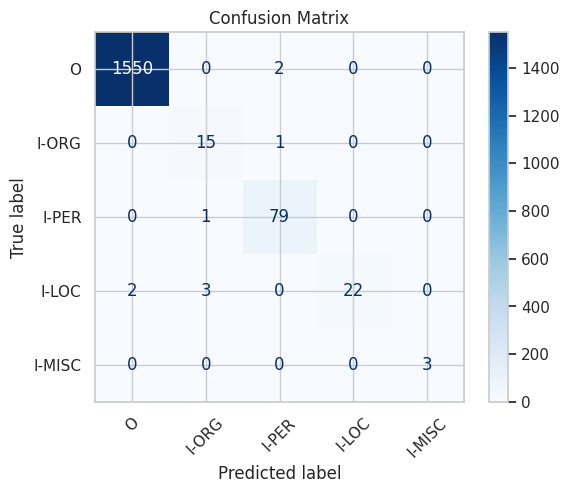

In [ ]:
# Get prediction on test data and predicted label

def get_predictions_and_labels(trainer, dataset):

    predictions, labels, _ = trainer.predict(dataset)

    predictions = np.argmax(predictions, axis=2)

    true_labels = [
        [label for label in label_seq if label != -100]
        for label_seq in labels
    ]
    pred_labels = [
        [pred for pred, label in zip(pred_seq, label_seq) if label != -100]
        for pred_seq, label_seq in zip(predictions, labels)
    ]

    true_labels = [item for sublist in true_labels for item in sublist]
    pred_labels = [item for sublist in pred_labels for item in sublist]

    return true_labels, pred_labels

true_labels, pred_labels = get_predictions_and_labels(trainer_fine_tuned, tokenized_datasets['test'])

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels, labels=list(tag2id.values()))

labels = [id2tag[id_] for id_ in tag2id.values()]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Specify the directory where the model files are saved
model_directory = "/content/drive/MyDrive/DataFellas"

# Load the fine-tuned model and tokenizer
from transformers import AutoModelForTokenClassification, AutoTokenizer

model = AutoModelForTokenClassification.from_pretrained(model_directory)  # Load the fine-tuned model
                                                                          # config: For model configuration.
                                                                          # model.safetensors: To load the trained weights.
                                                                          # tokenizer_config, special_tokens_map, vocab: For tokenizer configuration and token-to-ID mapping.
tokenizer = AutoTokenizer.from_pretrained(model_directory)

print("Model and tokenizer loaded successfully from:", model_directory)

Model and tokenizer loaded successfully from: /content/drive/MyDrive/DataFellas


The `predict_ner` function tokenizes a sentence, runs it through the fine-tuned model, and outputs the predicted NER labels for each word.
It handles sub-tokens, converts token IDs back to words, and prints each word with its corresponding predicted label. This allows you to see how the model classifies named entities in a new sentence.

In [ ]:

def predict_ner(sentence):
  '''
  Function to obtain a prediction as label
  '''
  inputs = tokenizer.encode_plus(
      sentence,
      return_tensors='pt',             # as PyTorch tensor
      is_split_into_words=False,       # input is a sentence
      truncation=True,
      max_length=28                    # of a sentence
  )
  input_ids = inputs['input_ids']

  model.eval()                         # Evaluation

  # Predictions
  with torch.no_grad():                # no gradient, use weights
      outputs = model(**inputs)
  predictions = torch.argmax(outputs.logits, dim=2)[0].numpy()    # select more probable class
  # Convertire input_ids in token
  tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

  # Rebuild sub-tokens
  words = []
  labels = []
  for idx, (token, pred) in enumerate(zip(tokens, predictions)):
      if token in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
          continue
      if token.startswith('##'):
          words[-1] += token[2:]
      else:
          words.append(token)
          labels.append(id2tag[pred])

  print("\nPredizione:")
  print("Parola\tEtichetta")
  for word, label in zip(words, labels):
      print(f"{word}\t{label}")


In [ ]:
print("\nEsempio di predizione:")
test_sentence = "Vittoria met Alessio in Milan to discuss finance trends."
predict_ner(test_sentence)
test_sentence = "Alberto analyzed bank data while walking through the streets of Venice."
predict_ner(test_sentence)


Esempio di predizione:

Predizione:
Parola	Etichetta
Vittoria	I-PER
met	O
Alessio	I-ORG
in	I-LOC
Milan	I-ORG
to	O
discuss	O
finance	O
trends	O
.	I-ORG

Predizione:
Parola	Etichetta
Alberto	O
analyzed	O
bank	I-ORG
data	O
while	O
walking	O
through	O
the	I-LOC
streets	I-LOC
of	I-LOC
Venice	I-ORG
.	I-ORG


# Conlcusion and Model comparison

The results from the BERT transformer-based model demonstrate exceptional performance across several key metrics, offering a well-balanced approach to precision, recall, and F1-score, all while maintaining high accuracy.

***High Precision and Recall***: BERT effectively identifies relevant instances (high recall) and ensures its predictions are accurate when assigning labels (high precision). This balance is crucial for tasks like Named Entity Recognition (NER) and document classification, where accurate entity identification is vital.

***Contextual Understanding***: Unlike simpler models such as Multinomial Naive Bayes, which may struggle with complex language relationships, BERT leverages its deep understanding of language context to capture nuances and subtleties in meaning. This deep contextual understanding significantly enhances its performance, especially on challenging tasks.
When compared to other deep learning models like LSTM, GRU, and BiLSTM, BERT outperforms them in several key areas, particularly when it comes to handling:

***Overall Performance***: Its ability to capture context and generalize well makes it a superior choice for complex NLP tasks.

**Advantages of BERT**

One of the standout advantages of BERT is its fine-tuning capability. Key benefits include:

> - ***Leverages Pre-trained Knowledge***: By fine-tuning a pre-trained transformer model, BERT can apply the knowledge gained from large-scale corpora to the task at hand. This pre-training makes it highly effective for many business contexts, where time and resources are limited.
> - ***Handling Imbalanced Datasets***: Fine-tuning is particularly useful when working with imbalanced datasets, a common challenge in many real-world NLP problems. While traditional machine learning models, such as Multinomial Naive Bayes, may perform poorly on such data, BERT can adjust to the data distribution during fine-tuning, providing more reliable results.

In conclusion, BERT is an excellent choice for NLP tasks that require deep contextual understanding. It performs exceptionally well in both imbalanced data scenarios and tasks requiring precise identification of entities or categories. BERT outperforms both traditional machine learning models like Naive Bayes and deep learning models such as LSTM, GRU, and BiLSTM, achieving superior accuracy, precision, recall, and F1-score.